In [ ]:
def estimate_sigma2_from_all_data(data):
    estimated_sigma2 = np.var(data)
    return estimated_sigma2


In [ ]:
def compute_P_star(y, t, k, sigma2, Pmin, Pmax):
    y_hat = np.sum(y[k:t]**2)
    t_k = t - k
    if t_k <= (2 * y_hat) / (Pmax + sigma2):
        P_star = Pmax
    elif t_k >= (2 * y_hat) / (Pmin + sigma2):
        P_star = Pmin
    else:
        P_star = (2 * y_hat) / (t_k + sigma2) - sigma2
    return P_star
def compute_g_t(y, t, k, sigma2, Pmin, Pmax):
    P_star = compute_P_star(y, t, k, sigma2, Pmin, Pmax)
    y_hat = np.sum(y[k:t]**2)
    t_k = t - k
    f_P = (P_star * y_hat) / (2 * (P_star + sigma2)) + (t_k / 2) * np.log(sigma2 / (P_star + sigma2))
    return f_P
def detect_changes(y, sigma2, Pmin, Pmax, h):
    n = len(y)
    S = np.zeros(n)
    for t in tqdm(range(1, n)):
        max_g_t = -np.inf
        for k in range(t):
            g_t = compute_g_t(y, t, k, sigma2, Pmin, Pmax)
            max_g_t = max(max_g_t, g_t)
        #
        # print("max_g_t" +str(max_g_t))
        # print("h" +str(h))
        if max_g_t > h:
            S[t] = S[t-1] + (max_g_t - h)
            # S[t] = g_t
        else:
            # print(0)
            S[t] = 0  # 重置累积值
    return S

def visualize_results(y, S):
    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Original Data')
    plt.title('Original Data')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(S, label='GLR-CUSUM Statistic', color='red')
    plt.title('GLR-CUSUM Statistic')
    plt.axhline(y=h, color='r', linestyle='--')
    plt.legend()
    plt.show()


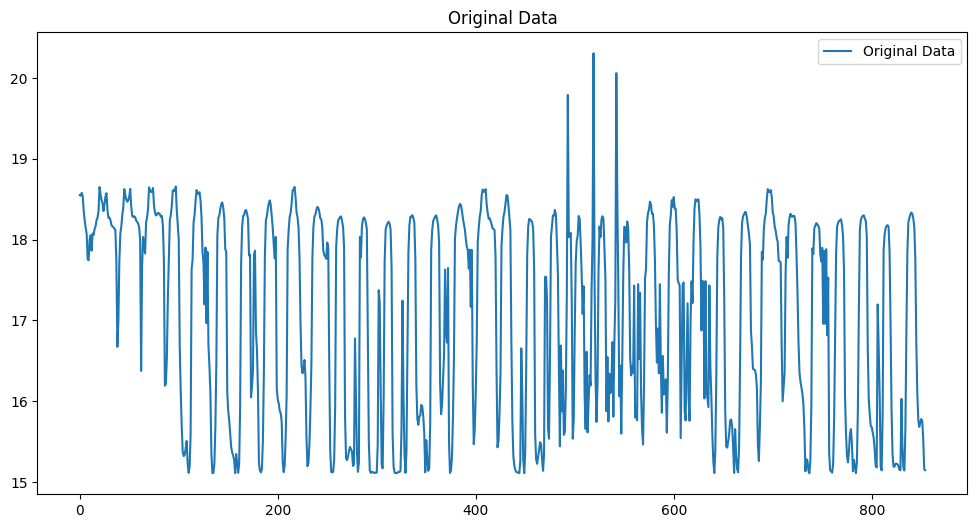

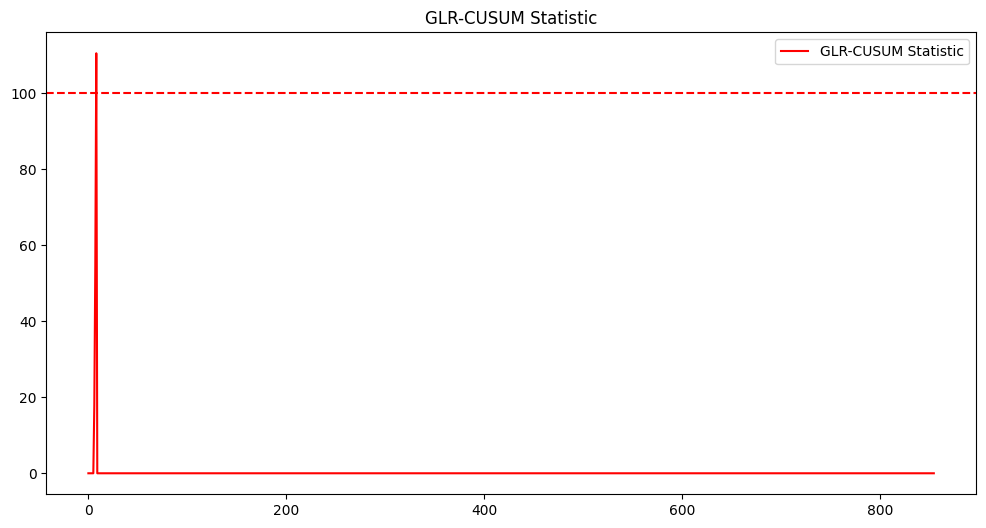

In [ ]:
y = bus_data[117][:, 0]  # 假设已经正确加载了数据

# 设定参数
sigma2 = estimate_sigma2_from_all_data(y)  # 噪声方差，假定已知
Pmin = 0.1  # 最小P值
Pmax = 0.9 # 最大P值
h = 100   # 变化检测阈值

# 检测变化
change_point, S = glr_cusum(y, sigma2, Pmin, Pmax, h)

# 可视化结果
visualize_results(y, S)

In [ ]:
# 该版本可用
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
# Helper function to parse CSV file
def parse_csv_file(file_path):
    df = pd.read_csv(file_path)
    return df

# Extract the last values for each bus
def extract_last_values(df, bus_numbers, n_values=855):
    bus_data = {}
    for bus in bus_numbers:
        bus_data[bus] = df[[f'Bus{bus}', 'Label']].values[-n_values:]
    return bus_data

def compute_glr_statistics(values, sigma2, p_min, p_max, h):
    n = len(values)
    g = np.zeros(n)
    for t in range(1, n):
        max_g = float('-inf')
        for k in range(1, t + 1):
            sum_sq = np.sum((values[k-1:t] - np.mean(values[k-1:t]))**2)
            p_star = max(p_min, min(p_max, 2 * sum_sq / (t-k+1) - sigma2))
            current_g = (p_star / (2 * (p_star + sigma2)) * sum_sq +
                         (t-k)*0.5 * np.log(sigma2 / (p_star + sigma2)))
            if current_g > max_g:
                max_g = current_g
        g[t] = max_g

    return g
def find_best_threshold(glr_stats, labels, thresholds):
    best_threshold = None
    min_delay = float('inf')
    min_change_detected_at = 0
    ids=[]
    for h in tqdm(thresholds):
        idx = 0
        detected_changes = 0
        ids.clear()
        for v in glr_stats:
          if idx>447 and v>h:
            detected_changes = idx
            ids.append(idx)
          idx+=1
        # print(ids)
        # detected_changes = np.where(glr_stats >= h)[0]
        if detected_changes > 0:
            change_detected_at = ids[0]
            # print("找到了" + str(change_detected_at))
            true_change_point = np.where(labels == 1)[0][0]
            delay = change_detected_at - true_change_point
            # print(str(change_detected_at)+ "的延迟是" + str(delay))
            if delay >= 0 and delay < min_delay:
                min_delay = delay
                best_threshold = h
                min_change_detected_at = change_detected_at

    return best_threshold, min_delay,min_change_detected_at


def estimate_sigma2_from_all_data(data):
    estimated_sigma2 = np.var(data)
    return estimated_sigma2

def standardize_data(values):
    """ 标准化给定的numpy数组或Pandas序列 """
    mean = np.mean(values)
    std = np.std(values)
    standardized_values = (values - mean) / std
    return standardized_values
# Parameters and data preparation

# p_max = 0.99
# p_min = 0.5
p_max = 0.99
p_min = 0.2
threshold = 0.2  # Threshold for detecting change
# Path to dataset
file_path = '/content/drive/MyDrive/ColabNotebooks/MSCProject/DataSet/LMPs/A_LMPFreq3_Labeled.csv'
df = parse_csv_file(file_path)
# Bus numbers and thresholds
bus_numbers = [115, 116, 117, 118, 119, 121, 135, 139]
bus_data = extract_last_values(df, bus_numbers)

In [ ]:
bus_number = 121


values, labels = bus_data[bus_number][:, 0], bus_data[bus_number][:, 1]
# Standardize the bus values
scaler = StandardScaler()
# standardized_values = scaler.fit_transform(values.reshape(-1, 1)).flatten()
standardized_values = standardize_data(values)
sigma2 = estimate_sigma2_from_all_data(standardized_values)
# Compute GLR statistics
glr_stats = compute_glr_statistics(standardized_values, sigma2, p_min, p_max, sigma2)

In [ ]:
# Find the best threshold for this bus
thresholds = np.linspace(0.2, 4, 100)  #  Sample thresholds to test
best_threshold, min_delay, change_detected_at = find_best_threshold(glr_stats, labels, thresholds)
# best_thresholds[bus] = (best_thresholxd, min_delay, change_detected_at)

100%|██████████| 100/100 [00:00<00:00, 5100.39it/s]


In [ ]:
change_detected_at

494

Text(0, 0.5, 'GLR Statistic')

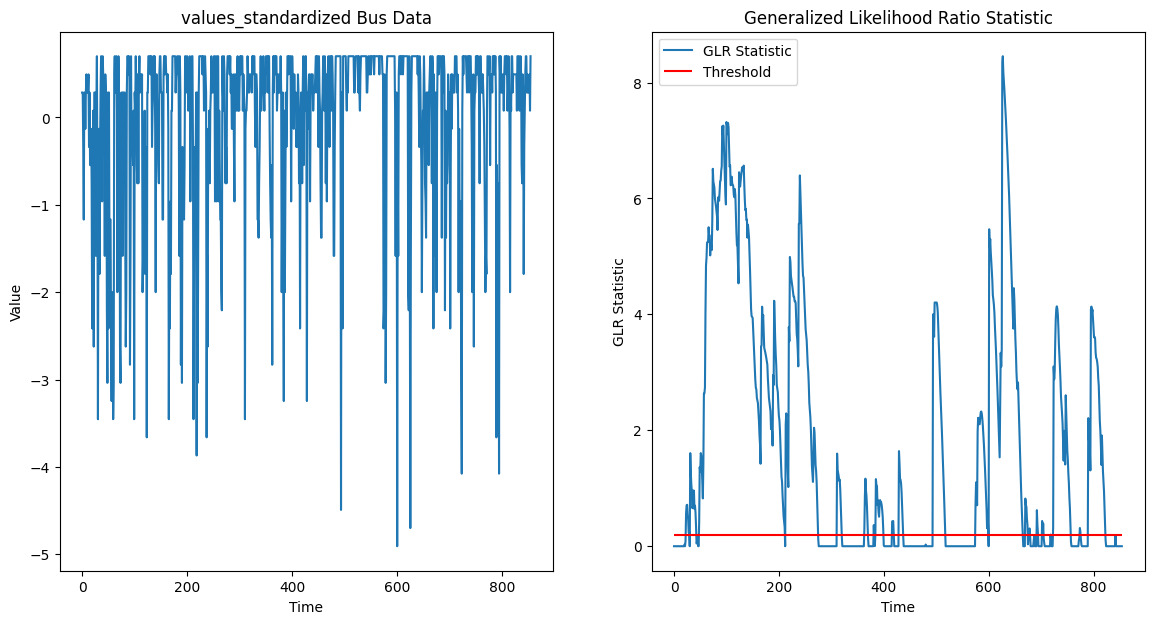

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(standardized_values)
plt.title('values_standardized Bus Data')
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(122)
plt.plot(glr_stats, label='GLR Statistic')
plt.hlines(best_threshold, 0, len(glr_stats), colors='r', label='Threshold')
plt.legend()
plt.title('Generalized Likelihood Ratio Statistic')
plt.xlabel('Time')
plt.ylabel('GLR Statistic')


In [ ]:
change_detected_at

494

In [ ]:
thresholds = np.linspace(0.2, 4, 100)  # Sample thresholds to test

min_delay = float('inf')
min_change_detected_at = None
# Processing each bus
best_thresholds = {}
for bus in bus_numbers:
    values, labels = bus_data[bus][:, 0], bus_data[bus][:, 1]
    # Standardize the bus values
    scaler = StandardScaler()
    standardized_values = scaler.fit_transform(values.reshape(-1, 1)).flatten()
    # Compute GLR statistics
    glr_stats = compute_glr_statistics(standardized_values, sigma2, p_min, p_max, sigma2)
    # Find the best threshold for this bus
    best_threshold, min_delay, min_change_detected_at = find_best_threshold(glr_stats, labels, thresholds)
    best_thresholds[bus] = (best_threshold, min_delay, min_change_detected_at)



100%|██████████| 100/100 [00:00<00:00, 4868.61it/s]


In [ ]:
# 试验不同的P_min和P_max
p_min_options = np.linspace(0.05, 0.5, 6)
p_max_options = np.linspace(0.5, 1.0, 6)
best_settings = {}
thresholds = np.linspace(0, 4, 100)
for bus in bus_numbers:
    values, labels = bus_data[bus][:, 0], bus_data[bus][:, 1]
    scaler = StandardScaler()
    standardized_values = scaler.fit_transform(values.reshape(-1, 1)).flatten()
    best_delay = float('inf')
    best_p_min = None
    best_p_max = None
    best_threshold = None

    for p_min in p_min_options:
        for p_max in p_max_options:
            glr_stats = compute_glr_statistics(standardized_values, sigma2, p_min, p_max, sigma2)
            best_threshold, min_delay, min_change_detected_at = find_best_threshold(glr_stats, labels, thresholds)
            if delay < best_delay:
                best_delay = min_delay
                best_p_min = p_min
                best_p_max = p_max
                best_threshold = best_threshold

    best_settings[bus] = {
        'p_min': best_p_min,
        'p_max': best_p_max,
        'threshold': best_threshold,
        'delay': best_delay,
        'change_detected_at':min_change_detected_at
    }

print(best_settings)

KeyboardInterrupt: 

In [ ]:
best_settings

In [ ]:
# Print the best thresholds and their corresponding delays
print("Best Thresholds and Delays per Bus:")
for bus, (thresh, delay,change_detected_at) in best_thresholds.items():
    print(f"Bus {bus}: Threshold = {thresh}, Delay = {delay}, change_detected_at = {change_detected_at}")

Best Thresholds and Delays per Bus:
Bus 115: Threshold = 0.3151515151515152, Delay = 24, change_detected_at = 494
Bus 116: Threshold = 0.3151515151515152, Delay = 19, change_detected_at = 489
Bus 117: Threshold = 0.2, Delay = 24, change_detected_at = 494
Bus 118: Threshold = 0.2, Delay = 1, change_detected_at = 471
Bus 119: Threshold = 0.2383838383838384, Delay = 24, change_detected_at = 494
Bus 121: Threshold = 0.2, Delay = 24, change_detected_at = 494
Bus 135: Threshold = 1.121212121212121, Delay = 3, change_detected_at = 473
Bus 139: Threshold = 1.812121212121212, Delay = 145, change_detected_at = 615


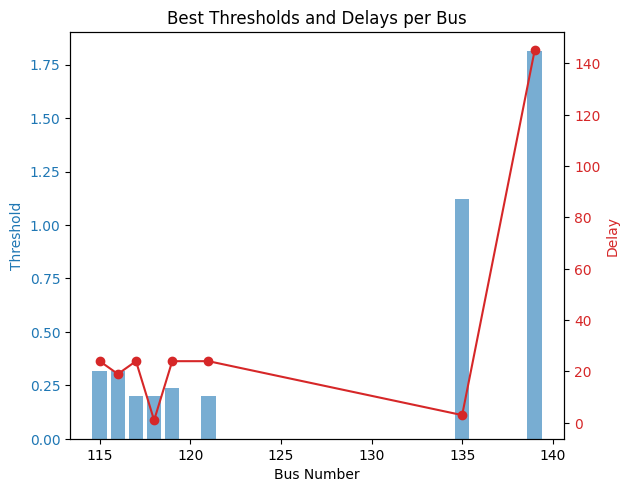

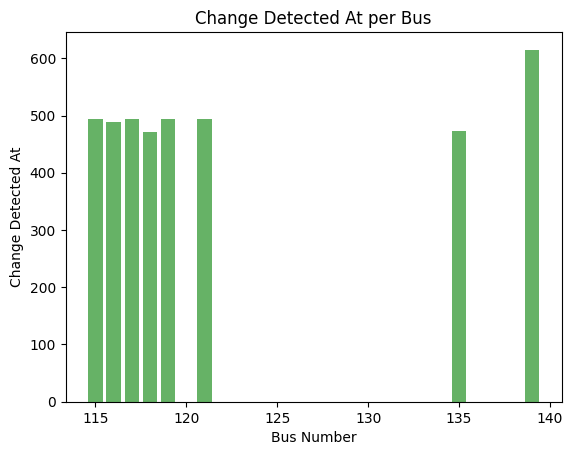

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据（假设best_thresholds已经定义）
# 示例： best_thresholds = {115: (0.8, 5), 116: (0.9, 3), 117: (1.2, 7), 118: (1.0, 2)}

# 提取bus编号、阈值和延迟
buses = list(best_thresholds.keys())
thresholds = [best_thresholds[bus][0] for bus in buses]
delays = [best_thresholds[bus][1] for bus in buses]
detected_change = [best_thresholds[bus][2] for bus in buses]

# 绘制阈值和延迟的图表
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Bus Number')
ax1.set_ylabel('Threshold', color=color)
ax1.bar(buses, thresholds, color=color, alpha=0.6, label='Threshold')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
color = 'tab:red'
ax2.set_ylabel('Delay', color=color)
ax2.plot(buses, delays, color=color, marker='o', label='Delay')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 调整布局以避免标签重叠
plt.title('Best Thresholds and Delays per Bus')
plt.show()

# 如果你想展示change_detected_at也可以类似地画出来
fig, ax3 = plt.subplots()

ax3.set_xlabel('Bus Number')
ax3.set_ylabel('Change Detected At')
ax3.bar(buses, detected_change, color='green', alpha=0.6, label='Change Detected At')
plt.title('Change Detected At per Bus')
plt.show()


In [ ]:
best_thresholds[115][2]


494

In [ ]:
# method A
best_settings = {
    115: {
        'p_min': 0.05,
        'p_max': 1.0,
        'threshold': 0.3151515151515152,
        'delay': 53,
        'change_detected_at': 523
    },
    116: {
        'p_min': 0.05,
        'p_max': 0.5,
        'threshold': 0.3151515151515152,
        'delay': 19,
        'change_detected_at': 489
    },
    117: {
        'p_min': 0.05,
        'p_max': 0.9,
        'threshold': 0.2,
        'delay': 53,
        'change_detected_at': 523
    },
    118: {
        'p_min': 0.5,
        'p_max': 1.0,
        'threshold': 0.2,
        'delay': float('inf'),
        'change_detected_at': 0
    },
    119: {
        'p_min': 0.5,
        'p_max': 1.0,
        'threshold': 0.2383838383838384,
        'delay': float('inf'),
        'change_detected_at': 0
    },
    121: {
        'p_min': 0.05,
        'p_max': 1.0,
        'threshold': 3.757575757575758,
        'delay': 24,
        'change_detected_at': 494
    },
    135: {
        'p_min': 0.5,
        'p_max': 1.0,
        'threshold': None,
        'delay': float('inf'),
        'change_detected_at': 0
    },
    139: {
        'p_min': 0.05,
        'p_max': 0.5,
        'threshold': 2.303030303030303,
        'delay': 146,
        'change_detected_at': 616
    }
}
for bus, (thresh, delay,change_detected_at) in best_thresholds.items():
    print(f"Bus {bus}: Threshold = {thresh}, Delay = {delay}, change_detected_at = {change_detected_at}")



labels = bus_data[bus_number][:, 1]
results = {
    bus: (
        best_thresholds[bus][0],  # 检测阈值
        labels,  # 对应bus的标签，这里使用假数据
        best_thresholds[bus][2],  # 检测到变化的时间
    ) for bus in best_thresholds
}

Bus 115: Threshold = 0.3151515151515152, Delay = 24, change_detected_at = 494
Bus 116: Threshold = 0.3151515151515152, Delay = 19, change_detected_at = 489
Bus 117: Threshold = 0.2, Delay = 24, change_detected_at = 494
Bus 118: Threshold = 0.2, Delay = 1, change_detected_at = 471
Bus 119: Threshold = 0.2383838383838384, Delay = 24, change_detected_at = 494
Bus 121: Threshold = 0.2, Delay = 24, change_detected_at = 494
Bus 135: Threshold = 1.121212121212121, Delay = 3, change_detected_at = 473
Bus 139: Threshold = 1.812121212121212, Delay = 145, change_detected_at = 615


In [ ]:
def voting_scheme(results, p_values):
    N = len(results)
    total_steps = 855
    votes = np.zeros((N, total_steps))

    for i, (bus, (_, labels, detection_time)) in enumerate(results.items()):
        if detection_time != -1:
            votes[i, detection_time:] = 1

    far_results = {}
    dd_results = {}

    for p in p_values:
        far_list = []
        dd_list = []
        for t in range(total_steps):
            if np.sum(votes[:, t]) >= p * N:
                detected_time = t
                real_change_points = np.where(labels == 1)[0]
                if len(real_change_points) > 0:
                    first_real_change = real_change_points[0]
                    delay = detected_time - first_real_change
                    if delay >= 0:
                        dd_list.append(delay)
                    else:
                        far_list.append(1)
                else:
                    far_list.append(1)
                break
        print(far_list)
        far_results[p] = np.mean(far_list) if far_list else 0
        dd_results[p] = np.mean(dd_list) if dd_list else 0

    return far_results, dd_results

# p值列表
p_values = [0.1, 0.2,0.3,0.4, 0.5, 0.7, 0.9]

# 计算不同p值下的FAR和DD
far_results, dd_results = voting_scheme(results, p_values)

[]
[]
[]
[]
[]
[]
[]


In [ ]:
def summarize_results(far_results, dd_results):
    print("Voting Scheme Results:")
    print(f"{'p-value':<10} {'FAR':<10} {'DD':<10}")
    for p in far_results.keys():
        print(f"{p:<10} {far_results[p]:<10.4f} {dd_results[p]:<10.4f}")

    best_p = min(far_results, key=far_results.get)
    print(f"\nBest p-value for FAR: {best_p} with FAR: {far_results[best_p]:.4f} and DD: {dd_results[best_p]:.4f}")

    best_p = min(dd_results, key=dd_results.get)
    print(f"Best p-value for DD: {best_p} with DD: {dd_results[best_p]:.4f} and FAR: {far_results[best_p]:.4f}")

summarize_results(far_results, dd_results)


Voting Scheme Results:
p-value    FAR        DD        
0.1        0.0000     1.0000    
0.2        0.0000     3.0000    
0.3        0.0000     19.0000   
0.4        0.0000     24.0000   
0.5        0.0000     24.0000   
0.7        0.0000     24.0000   
0.9        0.0000     145.0000  

Best p-value for FAR: 0.1 with FAR: 0.0000 and DD: 1.0000
Best p-value for DD: 0.1 with DD: 1.0000 and FAR: 0.0000


[0, 0, 0, 0, 0, 0, 0]


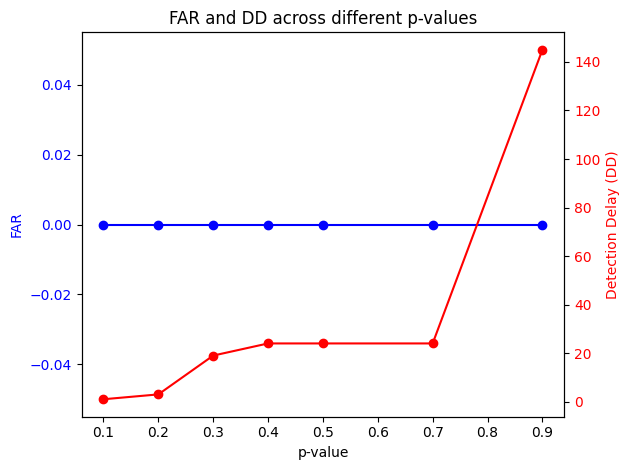

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# # 示例数据
# far_results = {0.1: 0.2, 0.2: 0.15, 0.3: 0.18, 0.4: 0.12, 0.5: 0.08, 0.6: 0.10, 0.7: 0.05, 0.8: 0.07, 0.9: 0.03, 1.0: 0.02}
# dd_results = {0.1: 20, 0.2: 18, 0.3: 22, 0.4: 15, 0.5: 12, 0.6: 10, 0.7: 8, 0.8: 7, 0.9: 6, 1.0: 5}

def visualize_results(far_results, dd_results):
    p_values = list(far_results.keys())
    far_values = list(far_results.values())
    dd_values = list(dd_results.values())
    print(far_values)
    fig, ax1 = plt.subplots()

    # 绘制FAR的柱状图
    ax1.plot(p_values, far_values, color='b', marker='o', label='FAR')
    ax1.set_xlabel('p-value')
    ax1.set_ylabel('FAR', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # 创建第二个Y轴来绘制DD折线图
    ax2 = ax1.twinx()
    ax2.plot(p_values, dd_values, color='r', marker='o', label='DD')
    ax2.set_ylabel('Detection Delay (DD)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # 添加图表标题
    plt.title('FAR and DD across different p-values')

    # 显示图例
    fig.tight_layout()
    plt.show()

visualize_results(far_results, dd_results)


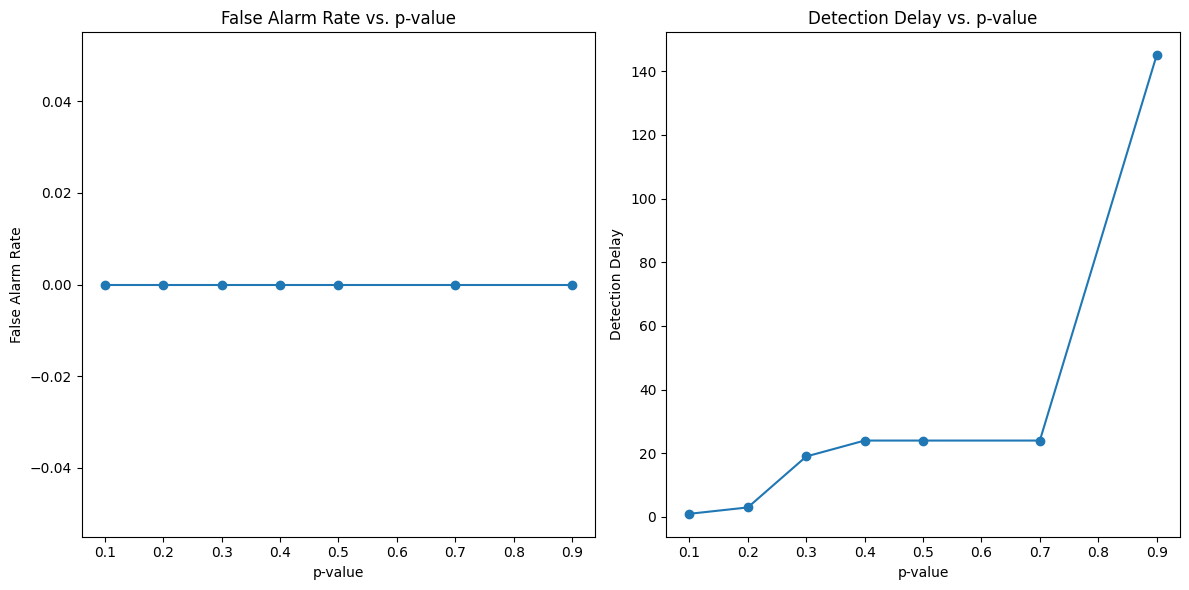

In [ ]:
def plot_voting_results(far_results, dd_results):
    p_values = list(far_results.keys())
    far_values = list(far_results.values())
    dd_values = list(dd_results.values())

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(p_values, far_values, marker='o')
    plt.title('False Alarm Rate vs. p-value')
    plt.xlabel('p-value')
    plt.ylabel('False Alarm Rate')

    plt.subplot(1, 2, 2)
    plt.plot(p_values, dd_values, marker='o')
    plt.title('Detection Delay vs. p-value')
    plt.xlabel('p-value')
    plt.ylabel('Detection Delay')

    plt.tight_layout()
    plt.show()

plot_voting_results(far_results, dd_results)


In [ ]:
# method B
best_threshold
for bus, (thresh, delay,change_detected_at) in best_thresholds.items():
    print(f"Bus {bus}: Threshold = {thresh}, Delay = {delay}, change_detected_at = {change_detected_at}")

Bus 115: Threshold = 0.3151515151515152, Delay = 24, change_detected_at = 494
Bus 116: Threshold = 0.3151515151515152, Delay = 19, change_detected_at = 489
Bus 117: Threshold = 0.2, Delay = 24, change_detected_at = 494
Bus 118: Threshold = 0.2, Delay = 1, change_detected_at = 471
Bus 119: Threshold = 0.2383838383838384, Delay = 24, change_detected_at = 494
Bus 121: Threshold = 0.2, Delay = 24, change_detected_at = 494
Bus 135: Threshold = 1.121212121212121, Delay = 3, change_detected_at = 473
Bus 139: Threshold = 1.812121212121212, Delay = 145, change_detected_at = 615


In [ ]:
best_threshold_for = {}
for bus, (thresh, delay,change_detected_at) in best_thresholds.items():
  if(thresh != None):
    best_threshold_for[bus] = thresh

best_threshold_for

{115: 0.3151515151515152,
 116: 0.3151515151515152,
 117: 0.2,
 118: 0.2,
 119: 0.2383838383838384,
 121: 0.2,
 135: 1.121212121212121,
 139: 1.812121212121212}

In [ ]:
# 全局阈值 H 的计算
H_values = {
    'mean': np.mean(list(best_threshold_for.values())),
    'min': np.min(list(best_threshold_for.values())),
    'max': np.max(list(best_threshold_for.values())),
    'median': np.median(list(best_threshold_for.values()))
}

In [ ]:
H_values

{'mean': 0.5502525252525252,
 'min': 0.2,
 'max': 1.812121212121212,
 'median': 0.2767676767676768}

In [ ]:
# 计算每个巴士的GLR统计量
def calculate_glr_statistics(bus_data, best_thresholds):
    bus_statistics = {}
    p_max = 0.99
    p_min = 0.2
    for bus, data in bus_data.items():
        values = data[:, 0]
        labels = data[:, 1]
        h = best_thresholds[bus]
        # central_value, spread = calculate_median_and_mad(values)
        # g = glr_cusum(values, central_value, spread, h)
        standardized_values = standardize_data(values)
        sigma2 = estimate_sigma2_from_all_data(standardized_values)
        # Compute GLR statistics
        glr_stats = compute_glr_statistics(standardized_values, sigma2, p_min, p_max, sigma2)


        # 找到第一个标签为1的索引
        attack_index = np.where(labels == 1)[0]
        first_attack_index = attack_index[0] if len(attack_index) > 0 else -1

        bus_statistics[bus] = (glr_stats, first_attack_index)
    return bus_statistics

In [ ]:
# 聚合函数：平均值聚合
def aggregate_statistics_mean(bus_statistics, H):
    total_steps = len(next(iter(bus_statistics.values()))[0])
    aggregated_values = np.zeros(total_steps)

    for t in range(450,total_steps):
        values_at_t = np.array([g[t] for g, _ in bus_statistics.values()])
        aggregated_values[t] = np.mean(values_at_t)

    detection_time = np.argmax(aggregated_values > H)
    # print(detection_time)
    if aggregated_values[detection_time] <= H:
        detection_time = -1
    return detection_time, aggregated_values
    # 计算检测延迟
def calculate_detection_delay_mean(bus_data, bus_statistics, H_values):
    results = {}

    for H_name, H_value in H_values.items():
        detection_time, _ = aggregate_statistics_mean(bus_statistics, H_value)
        real_change_points = [first_attack_index for _, first_attack_index in bus_statistics.values()]
        first_real_change = min(real_change_points)
        # print(first_real_change)
        results[H_name] = detection_time
        if detection_time != -1 and first_real_change != -1:
            delay = detection_time - first_real_change
            results[H_name] = delay if delay >= 0 else 'False Alarm'
        else:
            results[H_name] = 'False Alarm'
    return results

In [ ]:
# 计算不同全局阈值下的检测延迟
bus_statistics = calculate_glr_statistics(bus_data, best_thresholds)

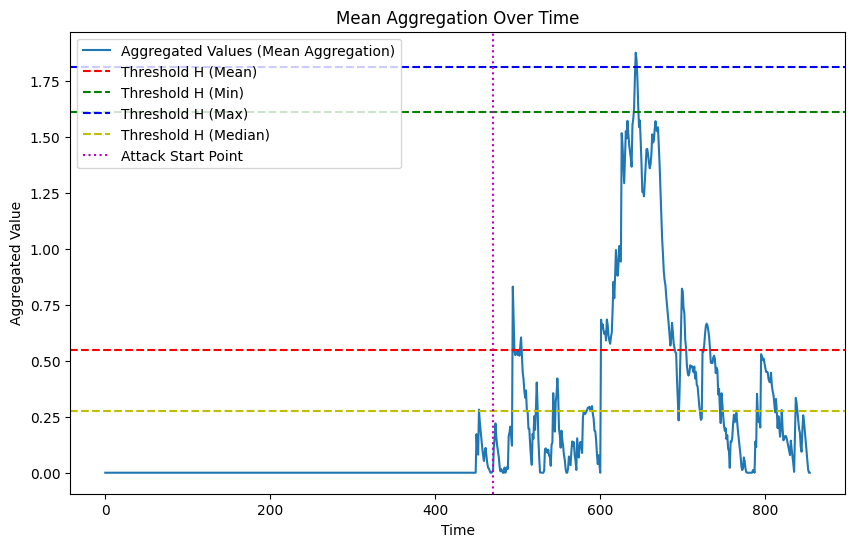

In [ ]:
detection_time, aggregated_values = aggregate_statistics_mean(bus_statistics, H_values['min'])
# 可视化 aggregated_values
plt.figure(figsize=(10, 6))
plt.plot(aggregated_values, label='Aggregated Values (Mean Aggregation)')
plt.axhline(y=H_values['mean'], color='r', linestyle='--', label='Threshold H (Mean)')
plt.axhline(y=H_values['min'], color='g', linestyle='--', label='Threshold H (Min)')
plt.axhline(y=H_values['max'], color='b', linestyle='--', label='Threshold H (Max)')
plt.axhline(y=H_values['median'], color='y', linestyle='--', label='Threshold H (Median)')
attack_start = 470
plt.axvline(x=attack_start, color='m', linestyle=':', label='Attack Start Point')
plt.xlabel('Time')
plt.ylabel('Aggregated Value')
plt.title('Mean Aggregation Over Time')
plt.legend(loc='upper left')
plt.show()

In [ ]:
detection_delays_mean = calculate_detection_delay_mean(bus_data, bus_statistics, H_values)
# 打印结果
for H_name, delay in detection_delays_mean.items():
    print(f"Global threshold H = {H_name}: Detection Delay = {delay}")

Global threshold H = mean: Detection Delay = 24
Global threshold H = min: Detection Delay = False Alarm
Global threshold H = max: Detection Delay = 173
Global threshold H = median: Detection Delay = False Alarm


In [ ]:
# 聚合函数：中位数聚合
def aggregate_statistics_median(bus_statistics, H):
    total_steps = len(next(iter(bus_statistics.values()))[0])
    aggregated_values = np.zeros(total_steps)

    for t in range(450,total_steps):
        values_at_t = np.array([g[t] for g, _ in bus_statistics.values()])
        aggregated_values[t] = np.median(values_at_t)
        # print(str(t) + ":"+str(aggregated_values[t]))
    detection_time = np.argmax(aggregated_values > H)
    print(detection_time)
    if aggregated_values[detection_time] <= H:
        detection_time = -1
    return detection_time, aggregated_values

In [ ]:
# 计算检测延迟
def calculate_detection_delay_median(bus_data, bus_statistics, H_values):
    results = {}

    for H_name, H_value in H_values.items():
        detection_time, _ = aggregate_statistics_median(bus_statistics, H_value)
        real_change_points = [first_attack_index for _, first_attack_index in bus_statistics.values()]
        first_real_change = min(real_change_points)
        if detection_time != -1 and first_real_change != -1:
            delay = detection_time - first_real_change
            results[H_name] = delay if delay >= 0 else 'False Alarm'
        else:
            results[H_name] = 'False Alarm'
    return results


In [ ]:

# 计算不同全局阈值下的检测延迟
detection_delays_median = calculate_detection_delay_median(bus_data, bus_statistics, H_values)



0
494
0
494


0


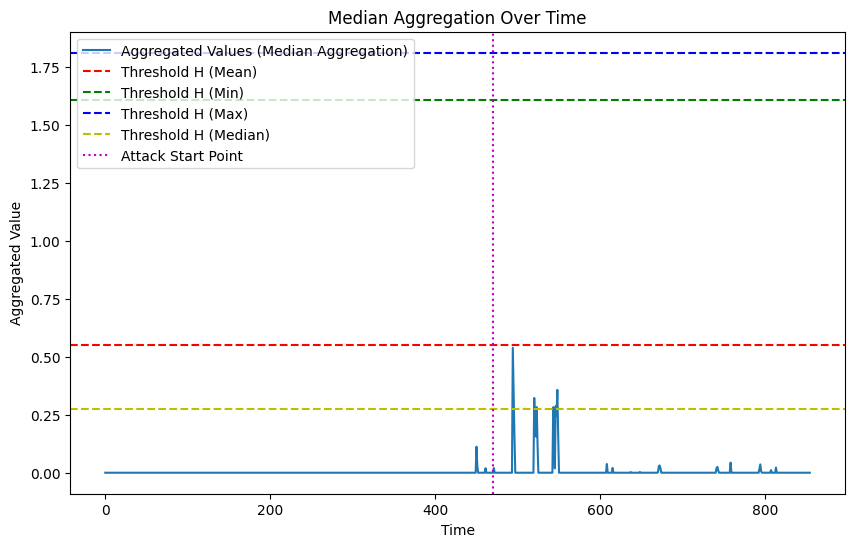

In [ ]:
detection_time, aggregated_values = aggregate_statistics_median(bus_statistics, H_values['min'])
H_values['min'] = 1.61
# 可视化 aggregated_values
plt.figure(figsize=(10, 6))
plt.plot(aggregated_values, label='Aggregated Values (Median Aggregation)')
plt.axhline(y=H_values['mean'], color='r', linestyle='--', label='Threshold H (Mean)')
plt.axhline(y=H_values['min'], color='g', linestyle='--', label='Threshold H (Min)')
plt.axhline(y=H_values['max'], color='b', linestyle='--', label='Threshold H (Max)')
plt.axhline(y=H_values['median'], color='y', linestyle='--', label='Threshold H (Median)')
attack_start = 470
plt.axvline(x=attack_start, color='m', linestyle=':', label='Attack Start Point')
plt.xlabel('Time')
plt.ylabel('Aggregated Value')
plt.title('Median Aggregation Over Time')
plt.legend(loc='upper left')
plt.show()

In [ ]:

# 打印结果
for H_name, delay in detection_delays_median.items():
    print(f"Global threshold H = {H_name}: Detection Delay = {delay}")

Global threshold H = mean: Detection Delay = False Alarm
Global threshold H = min: Detection Delay = 24
Global threshold H = max: Detection Delay = False Alarm
Global threshold H = median: Detection Delay = 24


In [ ]:
# 计算 MAD（中位数绝对偏差）
def mad(data, threshold=3.5):
    median = np.median(data)
    deviation = np.abs(data - median)
    mad_value = np.median(deviation)
    modified_z_score = 0.6745 * deviation / mad_value
    return data[modified_z_score < threshold]

# 聚合函数：异常值检测聚合
def aggregate_statistics_mad(bus_statistics, H):
    total_steps = len(next(iter(bus_statistics.values()))[0])
    aggregated_values = np.zeros(total_steps)

    for t in range(450,total_steps):
        values_at_t = np.array([g[t] for g, _ in bus_statistics.values()])
        filtered_values = mad(values_at_t)
        aggregated_values[t] = np.mean(filtered_values)

    detection_time = np.argmax(aggregated_values > H)
    print(detection_time)
    if aggregated_values[detection_time] <= H:
        detection_time = -1
    return detection_time, aggregated_values


In [ ]:
# 计算检测延迟：异常值检测聚合
def calculate_detection_delay_mad(bus_data, bus_statistics, H_values):
    results = {}

    for H_name, H_value in H_values.items():
        detection_time, _ = aggregate_statistics_mad(bus_statistics, H_value)
        real_change_points = [first_attack_index for _, first_attack_index in bus_statistics.values()]
        first_real_change = min(real_change_points)
        if detection_time != -1 and first_real_change != -1:
            delay = detection_time - first_real_change
            results[H_name] = delay if delay >= 0 else 'False Alarm'
        else:
            results[H_name] = 'False Alarm'
    return results
# 计算不同全局阈值下的检测延迟
detection_delays_mad = calculate_detection_delay_mad(bus_data, bus_statistics, H_values)


0
0
0
494


<ipython-input-34-1ec0b43f8919>:6: RuntimeWarning: divide by zero encountered in divide
  modified_z_score = 0.6745 * deviation / mad_value
<ipython-input-34-1ec0b43f8919>:6: RuntimeWarning: invalid value encountered in divide
  modified_z_score = 0.6745 * deviation / mad_value
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<ipython-input-34-1ec0b43f8919>:6: RuntimeWarning: divide by zero encountered in divide
  modified_z_score = 0.6745 * deviation / mad_value
<ipython-input-34-1ec0b43f8919>:6: RuntimeWarning: invalid value encountered in divide
  modified_z_score = 0.6745 * deviation / mad_value


494


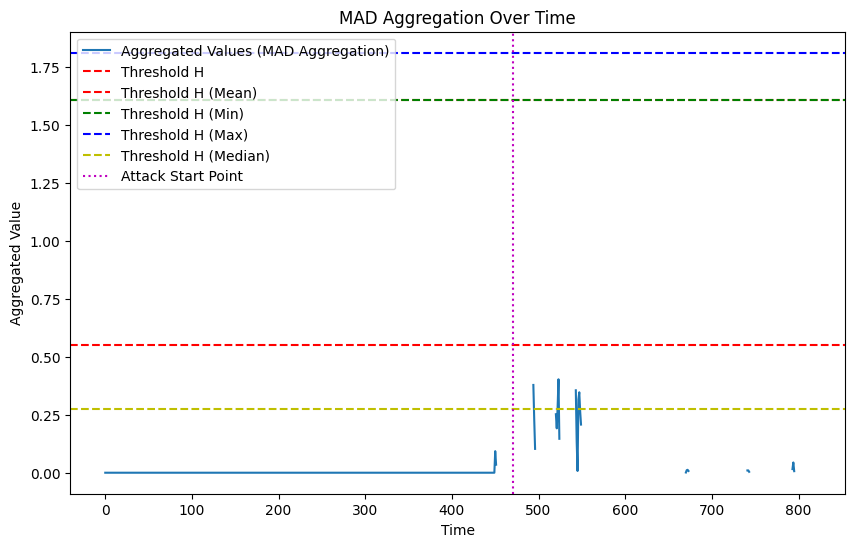

In [ ]:
detection_time, aggregated_values_1 = aggregate_statistics_mad(bus_statistics, H_values['median'])
# 可视化 aggregated_values
plt.figure(figsize=(10, 6))
plt.plot(aggregated_values_1, label='Aggregated Values (MAD Aggregation)')
plt.axhline(y=H_values['min'], color='r', linestyle='--', label='Threshold H')
plt.axhline(y=H_values['mean'], color='r', linestyle='--', label='Threshold H (Mean)')
plt.axhline(y=H_values['min'], color='g', linestyle='--', label='Threshold H (Min)')
plt.axhline(y=H_values['max'],  color='b', linestyle='--', label='Threshold H (Max)')
plt.axhline(y=H_values['median'], color='y', linestyle='--', label='Threshold H (Median)')
attack_start = 470
plt.axvline(x=attack_start, color='m', linestyle=':', label='Attack Start Point')
plt.xlabel('Time')
plt.ylabel('Aggregated Value')
plt.title('MAD Aggregation Over Time')
plt.legend(loc='upper left')
plt.show()

In [ ]:

# 打印结果
for H_name, delay in detection_delays_mad.items():
    print(f"Global threshold H = {H_name}: Detection Delay = {delay}")

Global threshold H = mean: Detection Delay = False Alarm
Global threshold H = min: Detection Delay = False Alarm
Global threshold H = max: Detection Delay = False Alarm
Global threshold H = median: Detection Delay = 24
